In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import xgboost as xgb
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Step 1: Load the datasets
arrivals_data = pd.read_csv(r"C:\Users\dines\OneDrive\Desktop\data\Detailed_Statistics_Arrivals.csv")
departures_data = pd.read_csv(r"C:\Users\dines\OneDrive\Desktop\data\Detailed_Statistics_Departures.csv")
weather_arrivals_data = pd.read_csv(r"C:\Users\dines\OneDrive\Desktop\data\weather_data_arrivals.csv")
weather_departures_data = pd.read_csv(r"C:\Users\dines\OneDrive\Desktop\data\weather_data_depature.csv")
   
# Print dataset
print("Arrivals Data:", arrivals_data)
print("Departures Data :", departures_data)
print("Weather Arrivals Data :", weather_arrivals_data)
print("Weather Departures Data :", weather_departures_data)

Arrivals Data:      Carrier Code Date (DD/MM/YYYY)  Flight Number Tail Number Origin Airport  \
0              DL        01-08-2024            314      N533DT            BOS   
1              DL        01-08-2024            315      N707TW            JFK   
2              DL        01-08-2024            340      N813DN            ATL   
3              DL        01-08-2024            361      N595NW            DTW   
4              DL        01-08-2024            399      N889DN            ATL   
...           ...               ...            ...         ...            ...   
1210           DL        31-08-2024           2074      N930DZ            MSP   
1211           DL        31-08-2024           2078      N928DU            MSP   
1212           DL        31-08-2024           2239      N371NW            LAX   
1213           DL        31-08-2024           2267      N832DN            LAX   
1214           DL        31-08-2024           2985      N133DU            SEA   

     Schedul

In [42]:
# Step 2: Clean and preprocess the flight data
# Standardize column names
arrivals_data.columns = [col.strip().replace(' ', '_').lower() for col in arrivals_data.columns]
departures_data.columns = [col.strip().replace(' ', '_').lower() for col in departures_data.columns]

# Parse the date column into datetime
arrivals_data['date'] = pd.to_datetime(arrivals_data['date_(dd/mm/yyyy)'], format='%d-%m-%Y', errors='coerce')
departures_data['date'] = pd.to_datetime(departures_data['date_(dd/mm/yyyy)'], format='%d-%m-%Y', errors='coerce')

# Print preprocessed data
print("Preprocessed Arrivals Data:", arrivals_data)
print("Preprocessed Departures Data:", departures_data)

Preprocessed Arrivals Data:      carrier_code date_(dd/mm/yyyy)  flight_number tail_number origin_airport  \
0              DL        01-08-2024            314      N533DT            BOS   
1              DL        01-08-2024            315      N707TW            JFK   
2              DL        01-08-2024            340      N813DN            ATL   
3              DL        01-08-2024            361      N595NW            DTW   
4              DL        01-08-2024            399      N889DN            ATL   
...           ...               ...            ...         ...            ...   
1210           DL        31-08-2024           2074      N930DZ            MSP   
1211           DL        31-08-2024           2078      N928DU            MSP   
1212           DL        31-08-2024           2239      N371NW            LAX   
1213           DL        31-08-2024           2267      N832DN            LAX   
1214           DL        31-08-2024           2985      N133DU            SEA   


In [43]:
# Step 3: Preprocess the weather data
weather_key_features = [
    'STATION',
    'DATE',
    'DailyAverageDryBulbTemperature',
    'DailyPrecipitation',
    'HourlyVisibility',
    'DailySustainedWindSpeed',
    'HourlyWindDirection'
]

weather_arrivals_data = weather_arrivals_data[weather_key_features]
weather_departures_data = weather_departures_data[weather_key_features]

# Parse the date column in weather data
weather_arrivals_data['DATE'] = pd.to_datetime(weather_arrivals_data['DATE'], errors='coerce')
weather_departures_data['DATE'] = pd.to_datetime(weather_departures_data['DATE'], errors='coerce')

# Print preprocessed weather data
print("Preprocessed Weather Arrivals Data:", weather_arrivals_data)
print("Preprocessed Weather Departures Data:", weather_departures_data)


Preprocessed Weather Arrivals Data:         STATION                DATE  DailyAverageDryBulbTemperature  \
0   99999923272 2024-08-01 23:59:00                            62.0   
1   99999923272 2024-08-02 23:59:00                            61.0   
2   99999923272 2024-08-03 23:59:00                            63.0   
3   99999923272 2024-08-04 23:59:00                            59.0   
4   99999923272 2024-08-05 23:59:00                            58.0   
5   99999923272 2024-08-06 23:59:00                            61.0   
6   99999923272 2024-08-07 23:59:00                            64.0   
7   99999923272 2024-08-08 23:59:00                            58.0   
8   99999923272 2024-08-09 23:59:00                            58.0   
9   99999923272 2024-08-10 23:59:00                            60.0   
10  99999923272 2024-08-11 23:59:00                            58.0   
11  99999923272 2024-08-12 23:59:00                            59.0   
12  99999923272 2024-08-13 23:59:00      

In [44]:
# Step 4: Merge flight data with weather data
arrivals_data_merged = arrivals_data.merge(weather_arrivals_data, how='left', left_on='date', right_on='DATE')
departures_data_merged = departures_data.merge(weather_departures_data, how='left', left_on='date', right_on='DATE')

# Combine arrivals and departures data into a unified dataset
flight_data = pd.concat([arrivals_data_merged, departures_data_merged], ignore_index=True)

# Print merged data
print("Merged Data:", flight_data)


Merged Data:      carrier_code date_(dd/mm/yyyy)  flight_number tail_number origin_airport  \
0              DL        01-08-2024            314      N533DT            BOS   
1              DL        01-08-2024            315      N707TW            JFK   
2              DL        01-08-2024            340      N813DN            ATL   
3              DL        01-08-2024            361      N595NW            DTW   
4              DL        01-08-2024            399      N889DN            ATL   
...           ...               ...            ...         ...            ...   
2055           DL        31-08-2024           2419      N3754A            NaN   
2056           DL        31-08-2024           2444      N399DA            NaN   
2057           DL        31-08-2024           2447      N399DA            NaN   
2058           DL        31-08-2024           2449      N381DN            NaN   
2059           DL        31-08-2024           2553      N367DN            NaN   

     scheduled

In [45]:
# Step 5: Handle missing values
flight_data.ffill(inplace=True)
flight_data = flight_data.infer_objects()

# Step 6: Create target variable (delay indicator)
flight_data['is_delayed'] = (flight_data['actual_arrival_time'] > flight_data['scheduled_arrival_time']).astype(int)

In [46]:
# Step 7: Feature engineering
# Add derived weather features
flight_data['temp_deviation'] = abs(flight_data['DailyAverageDryBulbTemperature'] - flight_data['DailyPrecipitation'])
flight_data['high_wind'] = (flight_data['DailySustainedWindSpeed'] > 15).astype(int)

# Convert categorical columns to numeric using Label Encoding
categorical_columns = ['carrier_code', 'origin_airport', 'destination_airport']
for col in categorical_columns:
    le = LabelEncoder()
    flight_data[col] = le.fit_transform(flight_data[col])

# Convert date-related features to useful numeric features
flight_data['day_of_week'] = flight_data['date'].dt.dayofweek
flight_data['month'] = flight_data['date'].dt.month


In [47]:
# Step 8: Remove non-numeric columns
X = flight_data.drop([
    'is_delayed',
    'actual_arrival_time',
    'scheduled_arrival_time',
    'date',
    'DATE',
    'date_(dd/mm/yyyy)',
    'tail_number',
    'scheduled_departure_time',
    'actual_departure_time'
], axis=1)

# Print X 
print("X:", X)

# Explicitly check if there are any non-numeric columns left in X
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    print("Non-numeric columns found:", non_numeric_columns)
    # Drop the non-numeric columns to avoid issues during model fitting
    X = X.drop(non_numeric_columns, axis=1)

# Target variable
y = flight_data['is_delayed']

# Print y 
print("y:", y)

X:       carrier_code  flight_number  origin_airport  arrival_delay_(minutes)  \
0                0            314               1                    -30.0   
1                0            315               3                     28.0   
2                0            340               0                     39.0   
3                0            361               2                    -11.0   
4                0            399               0                     32.0   
...            ...            ...             ...                      ...   
2055             0           2419               6                     -4.0   
2056             0           2444               6                     -4.0   
2057             0           2447               6                     -4.0   
2058             0           2449               6                     -4.0   
2059             0           2553               6                     -4.0   

      delay_carrier_(minutes)  delay_weather_(minutes)  \
0 

In [48]:
# Step 9: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print train and test shapes
print("X_train :", X_train)
print("X_test :", X_test)
print("y_train :", y_train)
print("y_test :", y_test)

X_train :       carrier_code  flight_number  origin_airport  arrival_delay_(minutes)  \
266              0            858               5                      3.0   
1133             0           1559               4                    -20.0   
1480             0            796               6                     -4.0   
1839             0           1070               6                     -4.0   
67               0            916               0                    -14.0   
...            ...            ...             ...                      ...   
1638             0           2447               6                     -4.0   
1095             0           1559               4                     20.0   
1130             0           1088               7                    -19.0   
1294             0           2419               6                     -4.0   
860              0            670               3                    -22.0   

      delay_carrier_(minutes)  delay_weather_(minutes

In [49]:
# Step 10: Build models
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Print RF model feature importances
print("RF Model Feature Importances:")
print(rf_model.feature_importances_)

# XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

RF Model Feature Importances:
[0.         0.05837284 0.04161226 0.60712375 0.05476268 0.00186042
 0.05617233 0.         0.02175758 0.         0.         0.
 0.         0.         0.         0.07438871 0.06881904 0.
 0.         0.0151304  0.        ]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       315
           1       0.92      0.97      0.94        97

    accuracy                           0.97       412
   macro avg       0.96      0.97      0.96       412
weighted avg       0.97      0.97      0.97       412



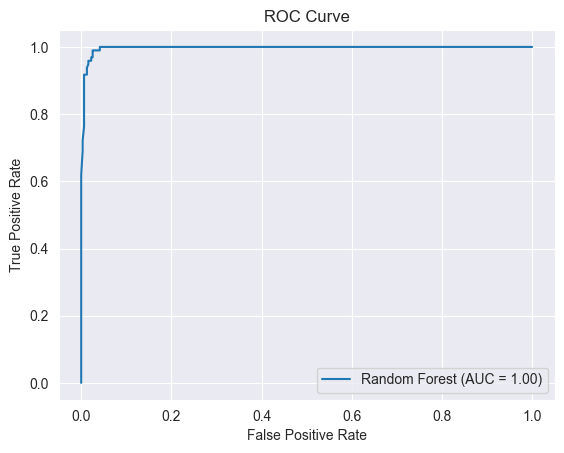

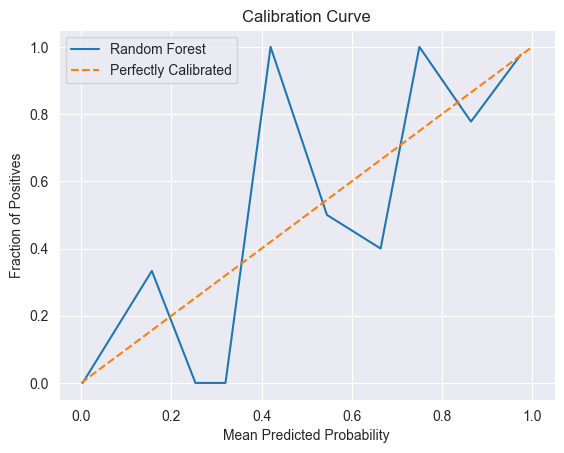

In [50]:
# Step 11: Evaluate models
# Random Forest predictions and probabilistic predictions
rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Classification report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, rf_probs)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

# Calibration Curve for Random Forest
prob_true, prob_pred = calibration_curve(y_test, rf_probs, n_bins=10)
plt.plot(prob_pred, prob_true, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [51]:
# Step 12: Incorporate uncertainty
# Monte Carlo simulations
simulated_uncertainty = []
for _ in range(100):
    # Simulate 100 variations
    perturbed_X = X_test.copy()
    perturbed_X['DailyPrecipitation'] += np.random.normal(0, 0.1, size=X_test.shape[0])
    simulated_uncertainty.append(rf_model.predict_proba(perturbed_X)[:, 1])

# Aggregate Monte Carlo results
simulated_uncertainty = np.array(simulated_uncertainty)
uncertainty_mean = simulated_uncertainty.mean(axis=0)
uncertainty_std = simulated_uncertainty.std(axis=0)

# Print uncertainty metrics
print("Uncertainty Mean:", uncertainty_mean)
print("Uncertainty Standard Deviation:", uncertainty_std)


Uncertainty Mean: [0.   0.   0.   0.   0.96 0.67 0.94 0.07 0.   0.57 0.   0.64 0.02 0.
 0.01 1.   1.   1.   0.01 0.   0.83 0.   0.94 0.   0.   0.99 0.09 0.97
 0.   0.01 0.   0.   0.   0.   0.24 0.   0.   0.   0.   0.01 0.   0.
 0.   0.42 0.   0.   0.99 0.   0.   0.   0.96 0.94 0.   0.95 0.91 1.
 0.   0.   0.   0.   0.93 0.   0.63 0.   0.   0.   0.   0.   0.01 0.
 0.9  0.97 0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.01 0.   0.
 0.   0.04 1.   0.01 0.98 0.   0.   0.98 0.   0.02 0.   0.   0.   1.
 0.   0.   0.   0.52 0.97 0.91 0.   0.99 0.   0.   0.   0.   0.91 0.
 0.   0.   0.99 0.99 0.69 1.   0.   0.   0.   0.01 0.99 0.   0.   0.18
 0.   0.   0.98 0.   0.01 0.9  0.   0.   0.   0.   0.   0.   0.   1.
 0.03 0.   0.   0.   0.   0.97 0.05 0.99 0.   0.   0.01 1.   0.   0.
 0.   0.96 0.01 0.   0.   0.02 0.   0.01 0.   0.   0.91 0.02 0.   0.
 0.   0.   0.98 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.03 0.
 0.   0.   0.26 1.   0.87 0.   0.   0.01 0.   0.01 0.01 0.   0.95 0.
 0.   0.   0

In [52]:
# Step 13: Save models and results
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')

# Save Monte Carlo uncertainty results
uncertainty_results = pd.DataFrame({'mean_prob': uncertainty_mean, 'std_dev': uncertainty_std})
uncertainty_results.to_csv('uncertainty_results.csv', index=False)